In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# Ê∑ªÂä†Áº∫Â§±ÁöÑvwapÂ≠óÊÆµÔºàÂ¶ÇÊûúÊú™Êèê‰æõÔºâ
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [5]:
def calculate_atr_adjusted_upper_shadow(df, rsi_window=14, atr_window=14):
    """
    Ê≥¢Âä®ÁéáË∞ÉÊï¥ÁöÑ‰∏äÂΩ±Á∫øÂõ†Â≠ê
    ÈáëËûçÂ≠¶ÂéüÁêÜÔºö
    1. Áî®ATRÊ†áÂáÜÂåñÊ∂àÈô§Â∏ÇÂú∫Ê≥¢Âä®ÂΩ±Âìç
    2. ÁªìÂêàVIXÂéüÁêÜÔºåÈ´òÊ≥¢Âä®Â∏ÇÂú∫‰∏≠ÁöÑ‰∏äÂΩ±Á∫øÊõ¥ÂÖ∑‰ø°ÊÅØÈáè
    3. ÂºïÂÖ•taker_buy_ratioÊçïÊçâÊú∫ÊûÑËµÑÈáëÊµÅÂêë
    """
    # ËÆ°ÁÆóATR
    df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=atr_window)
    
    # ËÆ°ÁÆóRSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    
    # ËÆ°ÁÆóÊú∫ÊûÑ‰π∞ÂÖ•ÊØîÁéá
    df['taker_buy_ratio'] = df['taker_buy_volume'] / df['volume']
    
    # Ê†∏ÂøÉÂõ†Â≠êËÆ°ÁÆó
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = (df['high'] - max_open_close) / df['atr']  # ATRÊ†áÂáÜÂåñ
    
    # Â¢ûÂº∫‰ø°Âè∑ÔºöË∂Ö‰π∞Âå∫‰∏îÊú∫ÊûÑÂçñÂá∫
    enhanced_signal = np.where(
        (df['rsi'] > 70) & (df['taker_buy_ratio'] < 0.5),
        upper_shadow * 1.8,
        upper_shadow
    )
    
    # Â∞æÈÉ®Â§ÑÁêÜÔºöËÆæÁΩÆÊúÄÂ∞èÊ≥¢Âä®ÈòàÂÄº
    return np.where(df['atr'] < 0.001 * df['close'], np.nan, enhanced_signal)

# Âõ†Â≠êÊµãËØï

In [6]:
evaluator.set_factor(
    factor_data_or_func=calculate_atr_adjusted_upper_shadow,
    factor_name='calculate_atr_adjusted_upper_shadow'
)


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.006581
   Rank_IC (Spearman): 0.000490
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: -0.427647
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 129608
   Âõ†Â≠êÂàó: calculate_atr_adjusted_upper_shadow
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


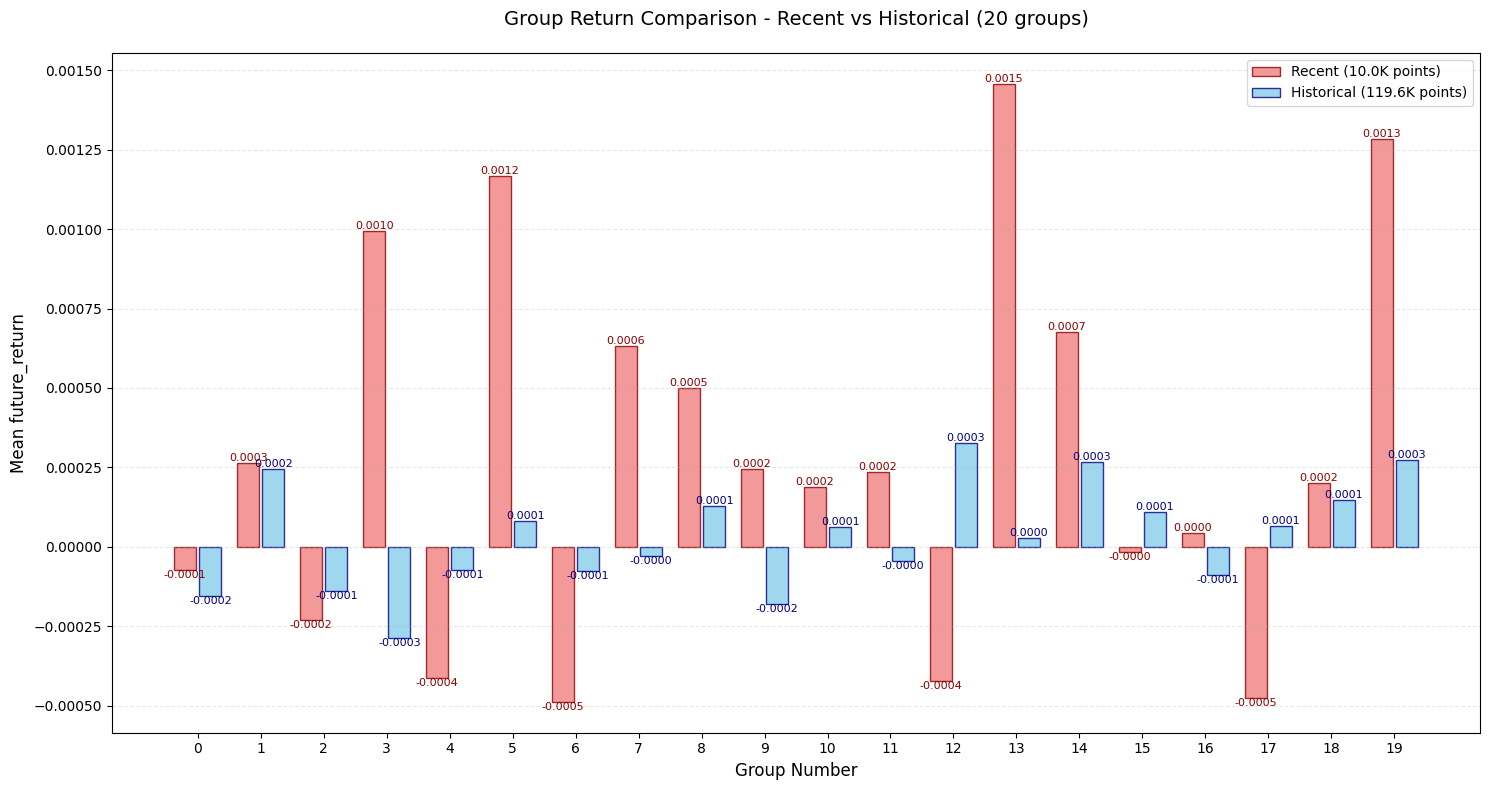

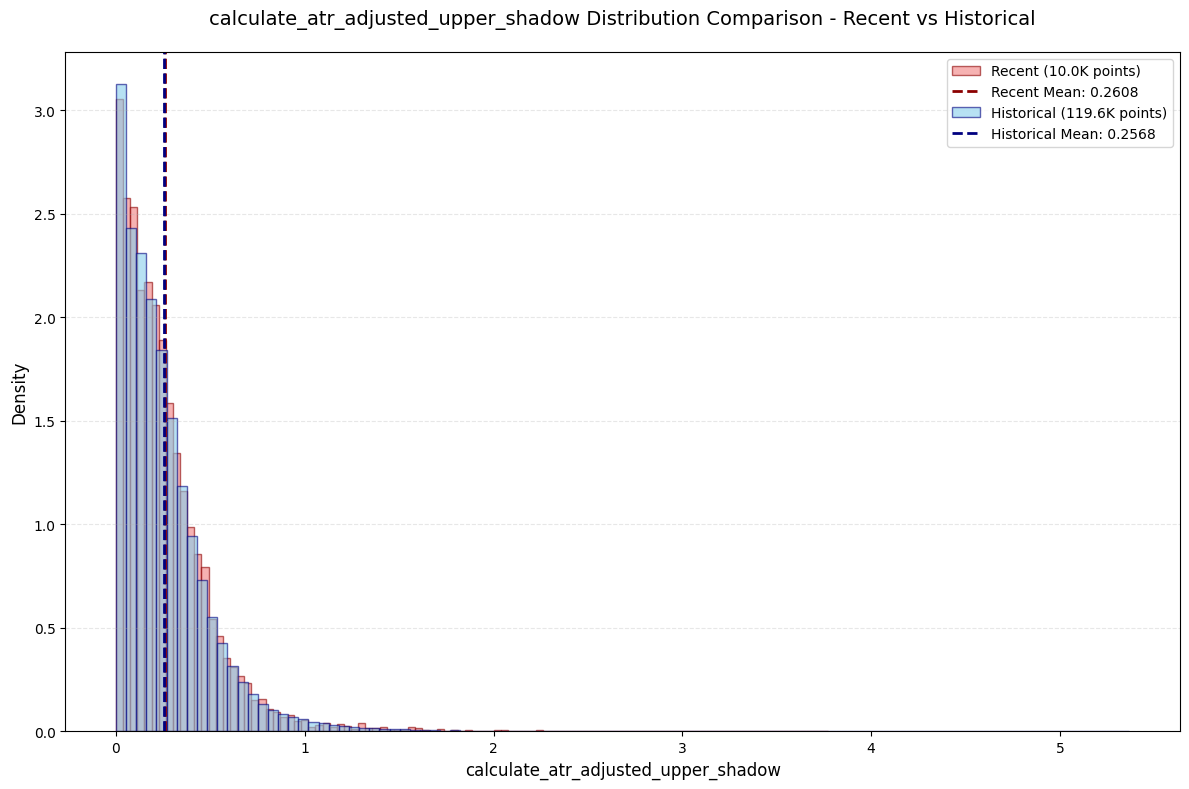

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [7]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)